### Савельев Николай, 774 группа

Авторегрессионная условная гетероскедастичность (англ. ARCH; AutoRegressive Conditional Heteroscedasticity) — применяемая в эконометрике модель для анализа временных рядов (в первую очередь финансовых), у которых условная (по прошлым значениям ряда) дисперсия ряда зависит от прошлых значений ряда, прошлых значений этих дисперсий и иных факторов. Данные модели предназначены для «объяснения» кластеризации волатильности на финансовых рынках, когда периоды высокой волатильности длятся некоторое время, сменяясь затем периодами низкой волатильности, причём среднюю (долгосрочную, безусловную) волатильность можно считать относительно стабильной.

Модели ARCH впервые были предложены Энглом в 1982 году. Уже в 1986 году Боллерслев предложил обобщение этих моделей (GARCH). В дальнейшем различные авторы предложили и иные варианты моделей данного типа, учитывающих те или иные особенности.

In [152]:
def arch_model(
    y,
    x = None,
    mean = "Constant",
    lags = 0,
    vol = "Garch",
    p = 1,
    o = 0,
    q = 1,
    power = 2.0,
    dist = "Normal",
    hold_back = None,
    rescale = None,
):
    
    known_mean = ("zero", "constant", "harx", "har", "ar", "arx", "ls")
    known_vol = ("arch", "figarch", "garch", "harch", "constant", "egarch")
    known_dist = (
        "normal",
        "gaussian",
        "studentst",
        "t",
        "skewstudent",
        "skewt",
        "ged",
        "generalized error",
    )
    mean = mean.lower()
    vol = vol.lower()
    dist = dist.lower()
    if mean not in known_mean:
        raise ValueError("Unknown model type in mean")
    if vol.lower() not in known_vol:
        raise ValueError("Unknown model type in vol")
    if dist.lower() not in known_dist:
        raise ValueError("Unknown model type in dist")

    if mean == "harx":
        am = HARX(y, x, lags, hold_back=hold_back, rescale=rescale)
    elif mean == "har":
        am = HARX(y, None, lags, hold_back=hold_back, rescale=rescale)
    elif mean == "arx":
        am = ARX(y, x, lags, hold_back=hold_back, rescale=rescale)
    elif mean == "ar":
        am = ARX(y, None, lags, hold_back=hold_back, rescale=rescale)
    elif mean == "ls":
        am = LS(y, x, hold_back=hold_back, rescale=rescale)
    elif mean == "constant":
        am = ConstantMean(y, hold_back=hold_back, rescale=rescale)
    else:  # mean == "zero"
        am = ZeroMean(y, hold_back=hold_back, rescale=rescale)

    if vol in ("arch", "garch", "figarch", "egarch") and not isinstance(p, int):
        raise TypeError(
            "p must be a scalar int for all volatility processes except HARCH."
        )

    if vol == "constant":
        v: VolatilityProcess = ConstantVariance()
    elif vol == "arch":
        assert isinstance(p, int)
        v = ARCH(p=p)
    elif vol == "figarch":
        assert isinstance(p, int)
        v = FIGARCH(p=p, q=q)
    elif vol == "garch":
        assert isinstance(p, int)
        v = GARCH(p=p, o=o, q=q, power=power)
    elif vol == "egarch":
        assert isinstance(p, int)
        v = EGARCH(p=p, o=o, q=q)
    else:  # vol == 'harch'
        v = HARCH(lags=p)

    if dist in ("skewstudent", "skewt"):
        d: Distribution = SkewStudent()
    elif dist in ("studentst", "t"):
        d = StudentsT()
    elif dist in ("ged", "generalized error"):
        d = GeneralizedError()
    else:  # ('gaussian', 'normal')
        d = Normal()

    am.volatility = v
    am.distribution = d

    return am

Iteration:      1,   Func. Count:     68,   Neg. LLF: 164.10497428694458
Iteration:      2,   Func. Count:    139,   Neg. LLF: 5509.831046321253
Iteration:      3,   Func. Count:    207,   Neg. LLF: 134.0297179165492
Iteration:      4,   Func. Count:    275,   Neg. LLF: 126.95947535319823
Iteration:      5,   Func. Count:    343,   Neg. LLF: 122.48054630546213
Iteration:      6,   Func. Count:    411,   Neg. LLF: 118.50389801516215
Iteration:      7,   Func. Count:    479,   Neg. LLF: 127.08749074557542
Iteration:      8,   Func. Count:    547,   Neg. LLF: 241.86027823957497
Iteration:      9,   Func. Count:    615,   Neg. LLF: 115.33175031175998
Iteration:     10,   Func. Count:    683,   Neg. LLF: 129.45188052719706
Iteration:     11,   Func. Count:    751,   Neg. LLF: 107.31262860161411
Iteration:     12,   Func. Count:    818,   Neg. LLF: 109.28761602874606
Iteration:     13,   Func. Count:    887,   Neg. LLF: 122.111755271053
Iteration:     14,   Func. Count:    955,   Neg. LLF: 1

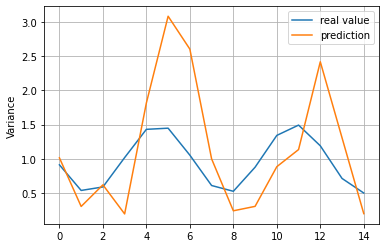

In [142]:
# example of GARCH model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
from arch import arch_model
import math
# seed pseudorandom number generator
seed(1)
# create dataset
data = [gauss(0, 1+0.5*math.sin(i)) for i in range(0,100)]
# split into train/test
n_test = 15
train, test = data[:-n_test], data[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=50, o=0, q=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
var = [1+0.5*math.sin(i) for i in range(0,100)]
plt.plot(var[-n_test:], label='real value')
# plot forecast variance
plt.plot(yhat.variance.values[-1, :], label='prediction')
plt.grid()
plt.legend()
plt.ylabel('Variance')
plt.show()